In [120]:
import SimpleITK as sitk
import numpy as np
from PIL import Image

# Load the PNG original image
image = np.array(
    Image.open(
        "/home/bearceb/mnt/QTIM/Non-IRB/Optimize_Projects/RIMR_project/Data/consensus_grading_11_16_2023/Ex1"
    ).convert("L")
)

users = [
  'bbearce', # 1/8
  'bmarks', # 8/8
  'cduic', # 8/8
  'climoli', # 8/8
  'fantaki', # 8/8
  'fsiddig', # 0/8
  'hkhalid', # 8/8
  'idimopoulos', # 8/8 - worried these don't have data
  'jhu', # 8/8
  'kmegid', # 8/8
  'kzhao', # 0/8
  'larguinchona', # 1/8
  'mjhingan', # 8/8
  'mprasad', # 0/8
  'nagi', # 8/8
  'ngim', # 5/8 - worried these don't have data
  'pesfahani', # 8/8
  'rchopra', # 8/8
  'smukherjee', # 8/8
  'tarunachalam', # 8/8
  'tkeenan', # 0/8
]

# Load the segmentations from three annotators
seg1 = np.array(Image.open("./1.png").convert("L"))
seg2 = np.array(Image.open("./2.png").convert("L"))
seg3 = np.array(Image.open("./3.png").convert("L"))

# Convert to integers
seg1_int = seg1.astype(np.int32)
seg2_int = seg2.astype(np.int32)
seg3_int = seg3.astype(np.int32)

# Threshold to binary mask #
seg1_binary = (seg1_int > 0).astype(np.int32)
seg2_binary = (seg2_int > 0).astype(np.int32)
seg3_binary = (seg3_int > 0).astype(np.int32)

# Convert to SimpleITK image objects
seg1_sitk = sitk.GetImageFromArray(seg1_binary)
seg2_sitk = sitk.GetImageFromArray(seg2_binary)
seg3_sitk = sitk.GetImageFromArray(seg3_binary)

# Run STAPLE algorithm
seg_stack = [seg1_sitk, seg2_sitk, seg3_sitk]
STAPLE_seg_sitk = sitk.STAPLE(seg_stack, 1)  # this can be changed

# Convert back to numpy array
STAPLE_seg = sitk.GetArrayFromImage(STAPLE_seg_sitk)

# Print statements to inspect the arrays
print("seg1_int:", seg1_int.shape, np.unique(seg1_int))
print("seg2_int:", seg2_int.shape, np.unique(seg2_int))
print("seg3_int:", seg3_int.shape, np.unique(seg3_int))

print("seg1_binary:", seg1_binary.shape, np.unique(seg1_binary))
print("seg2_binary:", seg2_binary.shape, np.unique(seg2_binary))
print("seg3_binary:", seg3_binary.shape, np.unique(seg3_binary))
print("STAPLE_seg:", STAPLE_seg.shape, np.unique(STAPLE_seg))

seg1_int: (1665, 1657) [ 0 76]
seg2_int: (1665, 1657) [  0  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 110 114 126]
seg3_int: (1665, 1657) [  0  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 106 114 126]
seg1_binary: (1665, 1657) [0 1]
seg2_binary: (1665, 1657) [0 1]
seg3_binary: (1665, 1657) [0 1]
STAPLE_seg: (1665, 1657) [0.         0.94324278 1.        ]


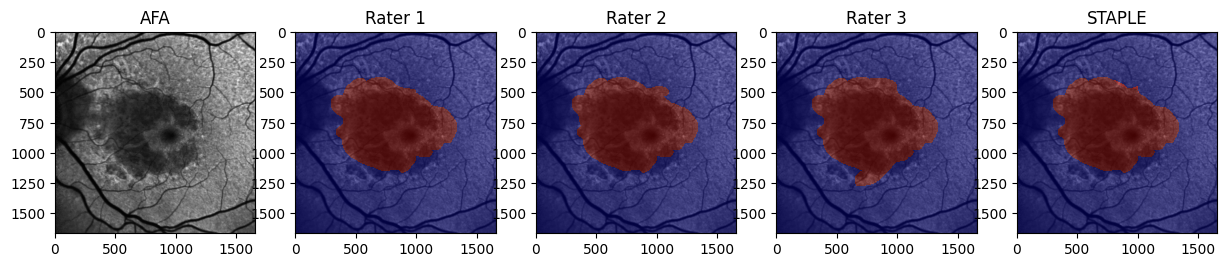

In [123]:
# visualize the staple result

from matplotlib import pyplot as plt

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))

# Display the original image
ax1.set_title("AFA")
ax1.imshow(image, cmap="gray")

# Display segmentations from each rater
ax2.set_title("Rater 1")
ax2.imshow(image, cmap="gray")
ax2.imshow(seg1_binary, cmap="jet", interpolation="none", alpha=0.5)

ax3.set_title("Rater 2")
ax3.imshow(image, cmap="gray")
ax3.imshow(seg2_binary, cmap="jet", interpolation="none", alpha=0.5)

ax4.set_title("Rater 3")
ax4.imshow(image, cmap="gray")
ax4.imshow(seg3_binary, cmap="jet", interpolation="none", alpha=0.5)

# Display STAPLE result
ax5.set_title("STAPLE")
ax5.imshow(image, cmap="gray")
ax5.imshow(STAPLE_seg, cmap="jet", interpolation="none", alpha=0.5)

plt.show()

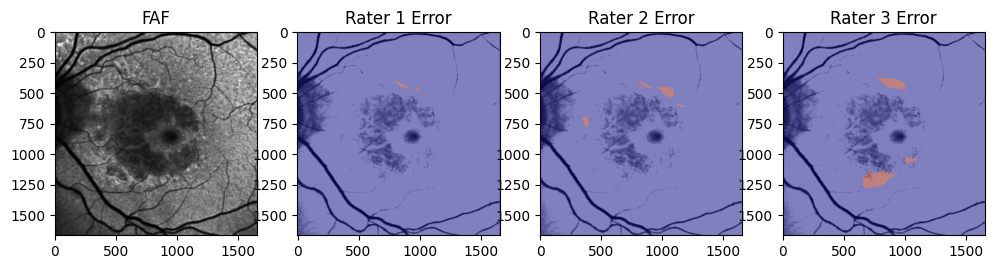

In [124]:
# get the error of each rater
seg1_err = np.zeros_like(STAPLE_seg)
seg1_err[np.where(STAPLE_seg != seg1_binary)] = 1

seg2_err = np.zeros_like(STAPLE_seg)
seg2_err[np.where(STAPLE_seg != seg2_binary)] = 1

seg3_err = np.zeros_like(STAPLE_seg)
seg3_err[np.where(STAPLE_seg != seg3_binary)] = 1

# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3))


ax1.set_title("FAF")
ax1.imshow(np.clip(image, -350, 450), cmap="gray")

# display segmentations from our three raters
ax2.set_title("Rater 1 Error")
ax2.imshow(np.clip(image, -350, 50), cmap="gray")
ax2.imshow(seg1_err, cmap="jet", interpolation="none", alpha=0.5)

ax3.set_title("Rater 2 Error")
ax3.imshow(np.clip(image, -350, 50), cmap="gray")
ax3.imshow(seg2_err, cmap="jet", interpolation="none", alpha=0.5)

ax4.set_title("Rater 3 Error")
ax4.imshow(np.clip(image, -350, 50), cmap="gray")
ax4.imshow(seg3_err, cmap="jet", interpolation="none", alpha=0.5)

plt.savefig("STAPLE_Error.png")
plt.show()

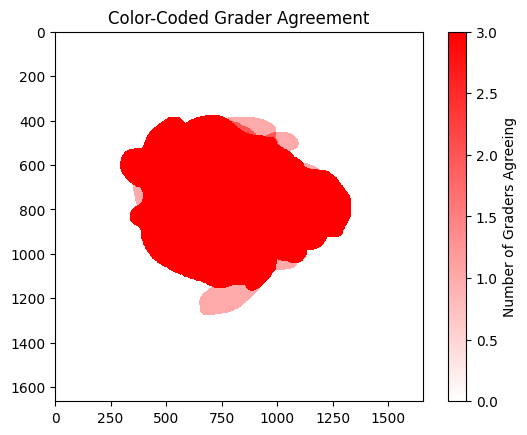

In [125]:
# based on the number of graders that called in 1 for each pixel, we can create a color-coded overlay of the agreement between the graders.

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Count the number of graders that called in 1 for each pixel
grader_counts = seg1_binary + seg2_binary + seg3_binary

# Define a custom colormap with a gradient from white to red
cmap_custom = mcolors.LinearSegmentedColormap.from_list(
    "white_to_red", ["#FFFFFF", "#FF0000"]
)

# Plot the STAPLE result with the colored overlay using the custom colormap
plt.imshow(grader_counts, cmap=cmap_custom, interpolation="none")
plt.colorbar(label="Number of Graders Agreeing")
plt.title("Color-Coded Grader Agreement")
plt.show()

# Overlay the STAPLE segmentation mask on top of the image  colormap
# plt.imshow(STAPLE_seg, cmap="jet", interpolation="none", alpha=0.5)  # Use the custom blue colormap for overlay
# plt.show()